<a href="https://colab.research.google.com/github/melodyjansen/IMDb-Reviews-SentimentAnalysis/blob/main/imdb_reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports & Preprocessing**

In [ ]:
# Import libraries
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Load dataset
df = pd.read_csv("show_data.csv")

In [ ]:
# Function to remove non-ASCII characters and strange symbols
def clean_symbols(text):
    if isinstance(text, str):
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        return text
    return text

# Apply the function to the Episode Title and Episode columns
df['Episode Title'] = df['Episode Title'].apply(clean_symbols)
df['Episode'] = df['Episode'].apply(clean_symbols)
df['User Review'] = df['User Review'].apply(clean_symbols)
df['Season'] = pd.to_numeric(df['Season'], errors='coerce')
df['Nth Episode'] = pd.to_numeric(df['Nth Episode'], errors='coerce')
df['User Rating'] = pd.to_numeric(df['User Rating'], errors='coerce')

# Add the total length of each show as a column
df['Total Episodes'] = df.groupby('TV Show')['Nth Episode'].transform('max')

# Verify the changes
print("Sample of Episode Title and Episode columns after removing non-ASCII characters:")
print(df.head())

Sample of Episode Title and Episode columns after removing non-ASCII characters:
           TV Show Avg Show Rating  \
0  1. Breaking Bad          9.5/10   
1  1. Breaking Bad          9.5/10   
2  1. Breaking Bad          9.5/10   
3  1. Breaking Bad          9.5/10   
4  1. Breaking Bad          9.5/10   

                                              Genres  Season   Episode  \
0  Desert Adventure, Drug Crime, Epic, Psychologi...     1.0  1  Pilot   
1  Desert Adventure, Drug Crime, Epic, Psychologi...     1.0  1  Pilot   
2  Desert Adventure, Drug Crime, Epic, Psychologi...     1.0  1  Pilot   
3  Desert Adventure, Drug Crime, Epic, Psychologi...     1.0  1  Pilot   
4  Desert Adventure, Drug Crime, Epic, Psychologi...     1.0  1  Pilot   

   Nth Episode Episode Title  Avg Episode Rating  \
0            1  S1.E1  Pilot                 9.0   
1            1  S1.E1  Pilot                 9.0   
2            1  S1.E1  Pilot                 9.0   
3            1  S1.E1  Pilot         

# **General stats**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Display general dataset information
print("Number of rows and columns:", df.shape)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Number of unique TV shows
unique_shows = df['TV Show'].nunique()
print("\nNumber of unique TV shows:", unique_shows)

# Number of unique episodes (considering TV Show, Episode Title, and Episode Description)
unique_episodes = df.groupby(['TV Show', 'Episode Title', 'Episode Description']).ngroups
print("Number of unique episodes:", unique_episodes)

# Average number of episodes per show included in dataset
avg_episodes_per_show = unique_episodes / unique_shows
print("Average number of episodes per show included in dataset:", avg_episodes_per_show)

# Calculate the actual average number of episodes per TV Show
unique_shows_df = df.copy()
unique_shows_df = unique_shows_df.drop_duplicates(subset='TV Show')
total_episodes_sum = unique_shows_df['Total Episodes'].sum()
total_tv_shows = unique_shows_df['TV Show'].nunique()
avg_episodes = total_episodes_sum / total_tv_shows
print("Average number of episodes per show:", avg_episodes)

# Average number of seasons per show
unique_seasons = df.groupby(['TV Show', 'Season']).ngroups
avg_seasons_per_show = unique_seasons / unique_shows
print("Average number of seasons per show:", avg_seasons_per_show)

Number of rows and columns: (76241, 12)

Missing values:
TV Show                   0
Avg Show Rating           0
Genres                    0
Season                  302
Episode                  10
Nth Episode               0
Episode Title             0
Avg Episode Rating        0
Episode Description      18
User Rating            4763
User Review               0
Total Episodes            0
dtype: int64

Number of unique TV shows: 246
Number of unique episodes: 10787
Average number of episodes per show included in dataset: 43.84959349593496
Average number of episodes per show: 66.64634146341463
Average number of seasons per show: 3.9471544715447155


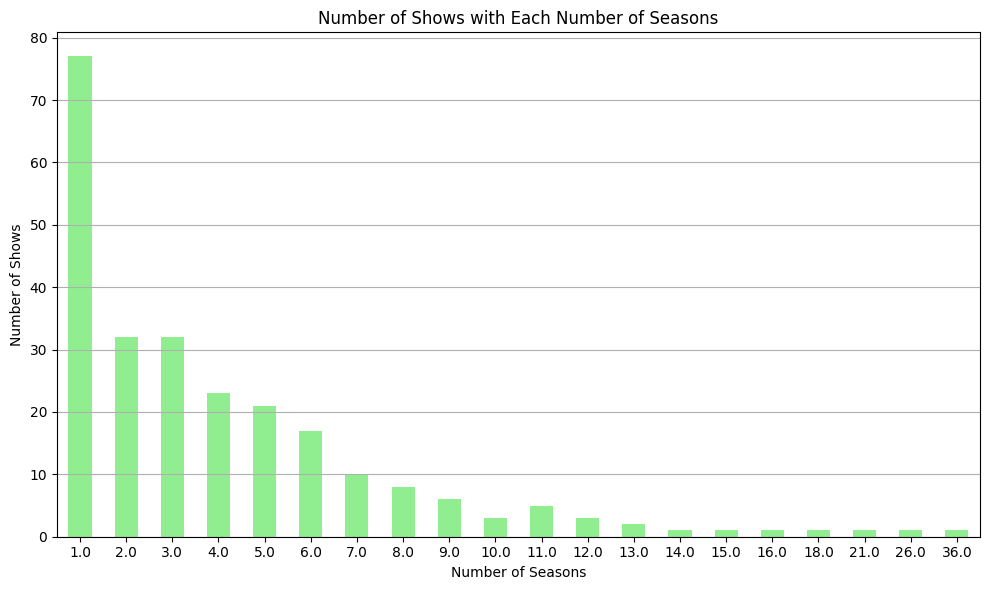

In [ ]:
# Get the maximum number of seasons for each show
max_seasons_per_show = df.groupby('TV Show')['Season'].max()

# Now we will count how many shows have a certain number of seasons
season_counts = max_seasons_per_show.value_counts().sort_index()

# Plotting the barplot
plt.figure(figsize=(10, 6))
season_counts.plot(kind='bar', color='lightgreen')

# Adding labels and title
plt.title('Number of Shows with Each Number of Seasons')
plt.xlabel('Number of Seasons')
plt.ylabel('Number of Shows')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

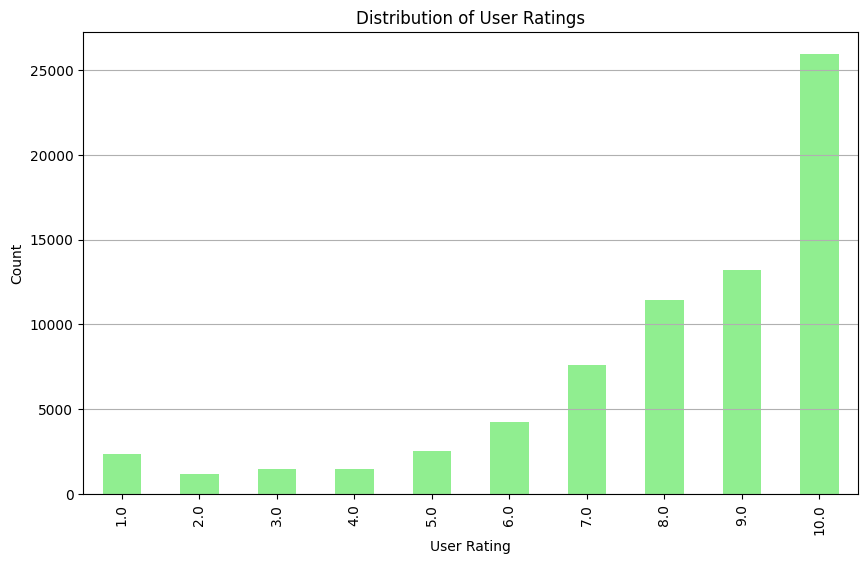

In [ ]:
import matplotlib.pyplot as plt

# Group the data by 'User Rating' and count occurrences
rating_counts = df['User Rating'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar', color='lightgreen')

# Add labels and title
plt.xlabel('User Rating')
plt.ylabel('Count')
plt.title('Distribution of User Ratings')
plt.grid(axis='y')

# Display the plot
plt.show()


Number of unique genres: 142


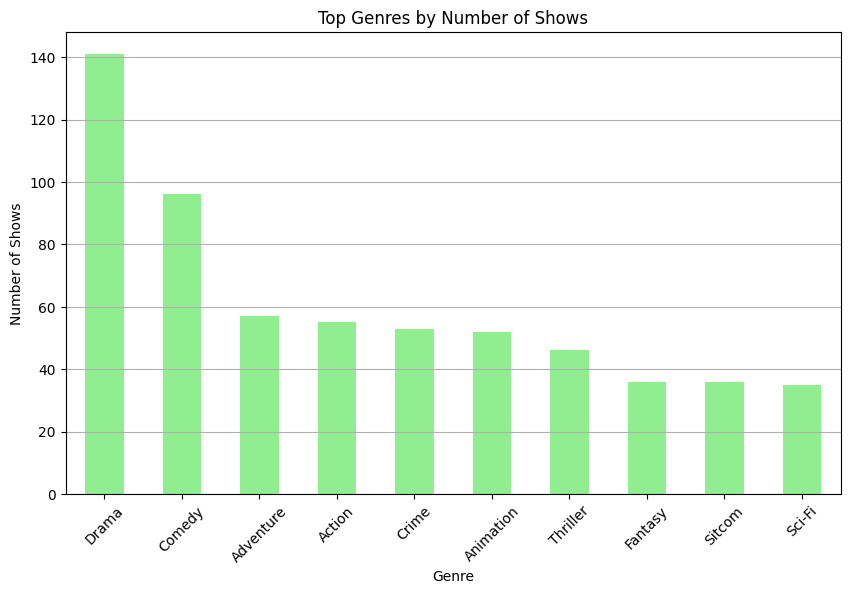

In [ ]:
# Number of unique genres
unique_genres = set()
df['Genres'].dropna().apply(lambda x: unique_genres.update(x.split(', ')))
print("\nNumber of unique genres:", len(unique_genres))

# Number of shows per genre
genres_split = df[['TV Show', 'Genres']].drop_duplicates()
genres_split['Genres'] = genres_split['Genres'].str.split(', ')
exploded_genres = genres_split.explode('Genres')
genre_show_counts = exploded_genres['Genres'].value_counts()

# Plot top genres by number of shows
plt.figure(figsize=(10, 6))
genre_show_counts.head(10).plot(kind='bar', color='lightgreen')
plt.title("Top Genres by Number of Shows")
plt.xlabel("Genre")
plt.ylabel("Number of Shows")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Most reviewed shows:
TV Show
103. The Simpsons                      5232
238. Doctor Who                        3438
107. Star Trek: The Next Generation    3352
20. The Twilight Zone                  3098
136. The X Files                       3032
82. South Park                         2182
52. Friends                            1861
39. Seinfeld                           1649
27. The Office                         1471
13. Game of Thrones                    1460
Name: count, dtype: int64


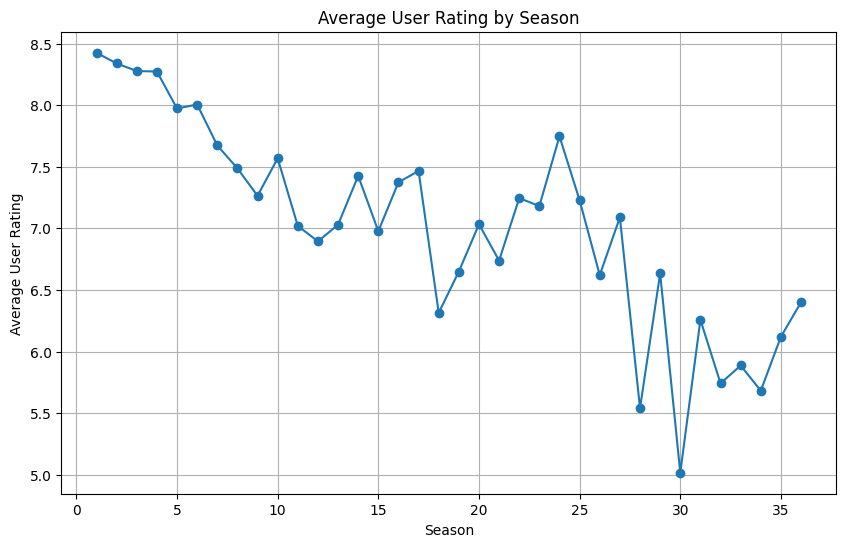

In [ ]:
# Most reviewed shows
most_reviewed_shows = df['TV Show'].value_counts().head(10)
print("\nMost reviewed shows:")
print(most_reviewed_shows)

# Average user rating by season
avg_user_rating_by_season = df.groupby('Season')['User Rating'].mean()

# Plot average user rating by season
plt.figure(figsize=(10, 6))
plt.plot(avg_user_rating_by_season.index, avg_user_rating_by_season.values, marker='o')
plt.title('Average User Rating by Season')
plt.xlabel('Season')
plt.ylabel('Average User Rating')
plt.grid()
plt.show()

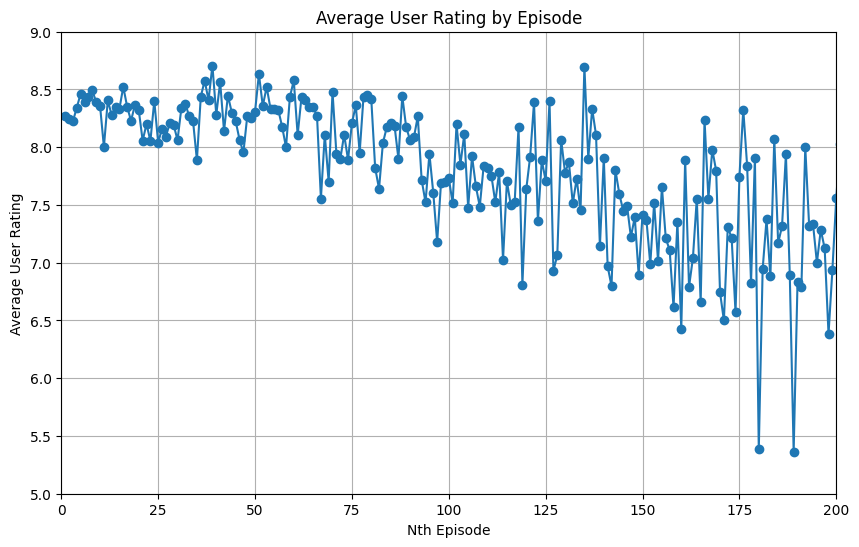

In [ ]:
# Average user rating by season
avg_user_rating_by_ep = df.groupby('Nth Episode')['User Rating'].mean()

# Plot average user rating by season
plt.figure(figsize=(10, 6))
plt.plot(avg_user_rating_by_ep.index, avg_user_rating_by_ep.values, marker='o')
plt.title('Average User Rating by Episode')
plt.xlabel('Nth Episode')
plt.ylabel('Average User Rating')
plt.grid()
plt.xlim(0, 200)
plt.ylim(5,9)
plt.show()

# **Sentiment Analysis**

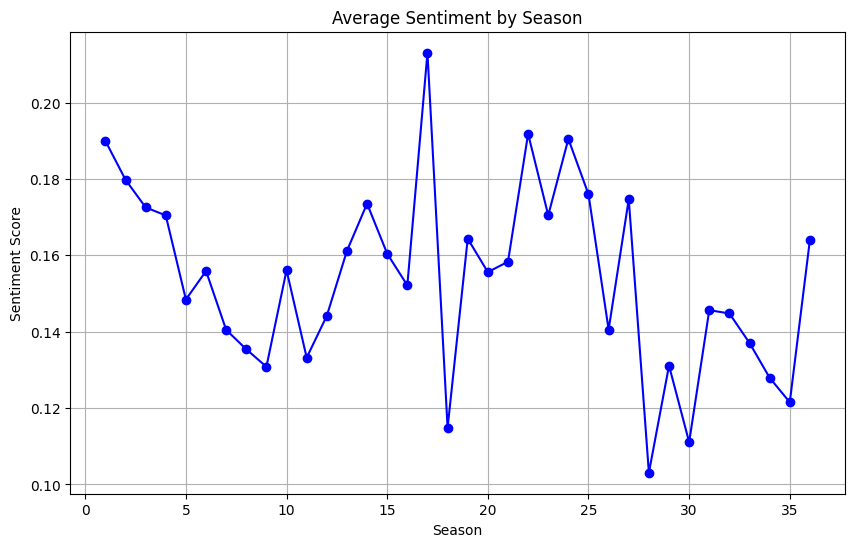

In [ ]:
# Assign sentiment scores
df['Sentiment Score'] = df['User Review'].apply(lambda review: TextBlob(review).sentiment.polarity)

# Ensure the Season column is numeric for grouping
df['Season'] = pd.to_numeric(df['Season'], errors='coerce')

# Group by Season and calculate the mean sentiment score
sentiment_by_season = df.groupby('Season')['Sentiment Score'].mean()

# Plot sentiment by season
plt.figure(figsize=(10, 6))
plt.plot(sentiment_by_season.index, sentiment_by_season.values, marker='o', color='b')
plt.title("Average Sentiment by Season")
plt.xlabel("Season")
plt.ylabel("Sentiment Score")
plt.grid()
plt.show()

As can be seen in the graph, the average sentiment score per season does not seem to follow a clear trend. We may be able to argue that we can see a declining sentiment score for the first 9 seasons, but this trend does not continue after. We may reason that not many shows extend beyond this amount of seasons, therefore, the data we base ourselves on decreases and becomes more and more irregular. We must definitely keep in mind that seasons not always tell us much about the longevity of a show. Some shows may have seasons consisting of 6 episodes, other shows have seasons consisting of 20 episodes. Therefore, we will now look at the average sentiment scoring based on episode number.

**Sentiment by episode**

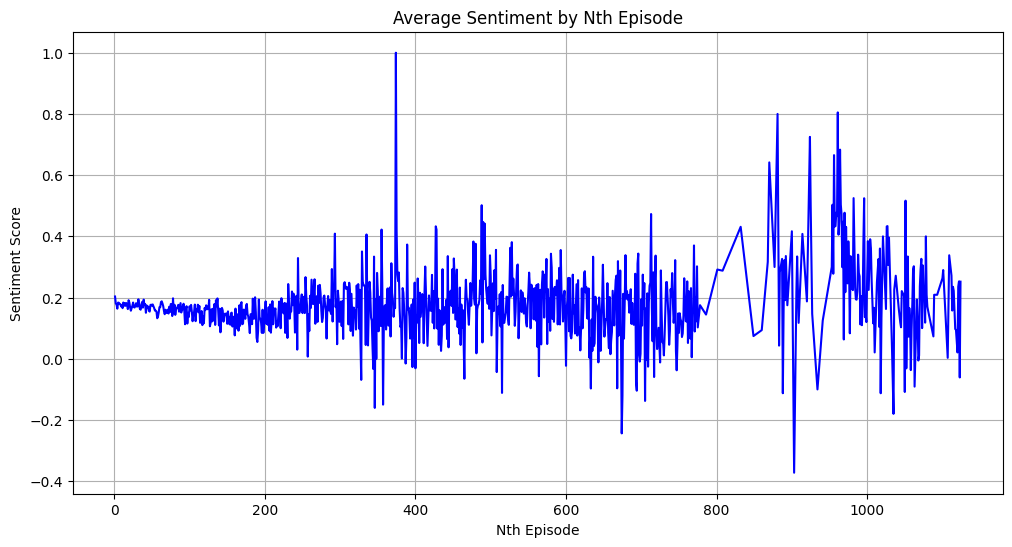

In [ ]:
# Group by Nth episode and calculate the mean sentiment score
sentiment_by_episode = df.groupby('Nth Episode')['Sentiment Score'].mean()

# Sort by numeric index
sentiment_by_episode = sentiment_by_episode.sort_index()

# Plot sentiment by Nth episode
plt.figure(figsize=(12, 6))
plt.plot(sentiment_by_episode.index, sentiment_by_episode.values, linestyle='-', color='b')
plt.title("Average Sentiment by Nth Episode")
plt.xlabel("Nth Episode")
plt.ylabel("Sentiment Score")
plt.grid()
plt.show()

The graph above is quite messy. The x-axis goes up to beyond a 1000 episodes, as our longest running show (One Piece: Stampede) consists of 1137 episodes. Therefore, we will try to see if we can see more detail once we divide the graph up into several graphs.

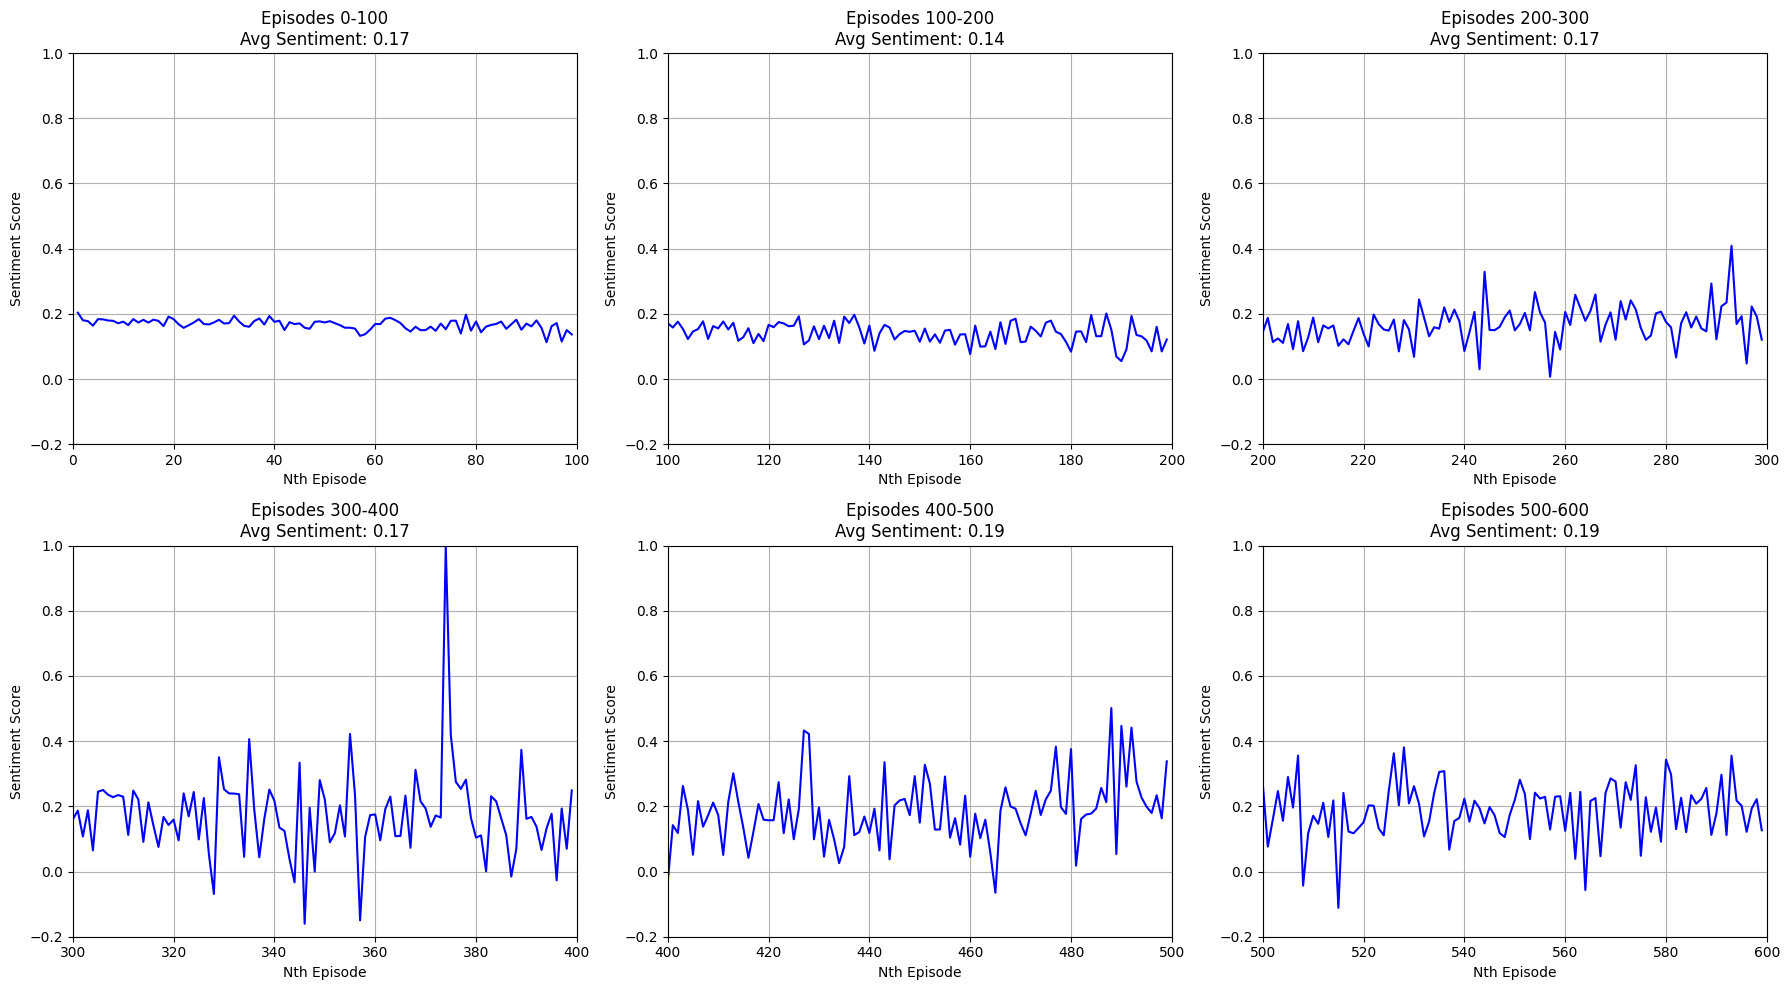

In [ ]:
import matplotlib.pyplot as plt

# Define the number of subplots and the range for each subplot
num_subplots = 6
x_ranges = [(i * 100, (i + 1) * 100) for i in range(num_subplots)]

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows and 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier iteration

for ax, (start, end) in zip(axes, x_ranges):
    # Filter data for the current range
    interval_data = sentiment_by_episode[(sentiment_by_episode.index >= start) & (sentiment_by_episode.index < end)]

    # Calculate the average sentiment score for the interval
    avg_sentiment = interval_data.mean()

    # Plot the data
    ax.plot(interval_data.index, interval_data.values, linestyle='-', color='b')
    ax.set_xlim(start, end)
    ax.set_ylim(-0.2, 1)
    ax.set_title(f"Episodes {start}-{end}\nAvg Sentiment: {avg_sentiment:.2f}")
    ax.set_xlabel("Nth Episode")
    ax.set_ylabel("Sentiment Score")
    ax.grid()

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

Above, we are able to see the graph in much more detail than we could before. However, we can also view how volatile our scoring becomes once the episode number goes up. Once again, with the increase of the episode number, we have less data to rely on. We can see a major jump between episodes 370 and 380, so let us look at this outlier.

In [ ]:
# Filter data for episodes between 370 and 380
outlier_data = sentiment_by_episode[(sentiment_by_episode.index >= 370) & (sentiment_by_episode.index <= 380)]

# Print or inspect the data
print(outlier_data)

Nth Episode
370    0.193662
371    0.137285
372    0.172016
373    0.165677
374    1.000000
375    0.418690
376    0.275159
377    0.253732
378    0.281970
379    0.163982
380    0.104109
Name: Sentiment Score, dtype: float64


We observe that episode 374 on average has a sentiment score 1.0. Looking into our dataset, we are able to see that only one show has a 374th episode with a user review on IMDB, and it is really only one user review. This average sentiment score is therefore based on a single review, and can not tell us anything about the 374th episode of other shows. For that matter, it can not even tell us much about the 374th episode of the show it is written for (The Simpsons). While this particular reviewer rated it a 10/10, the average rating for this episode of the show is a 6.7/10. Suggesting a bit of an outlier in sentiment regarding this episode.

As we have seen earlier, every show on average contains roughly 67 episodes. Therefore, we will now zoom in on the first 100 episodes.

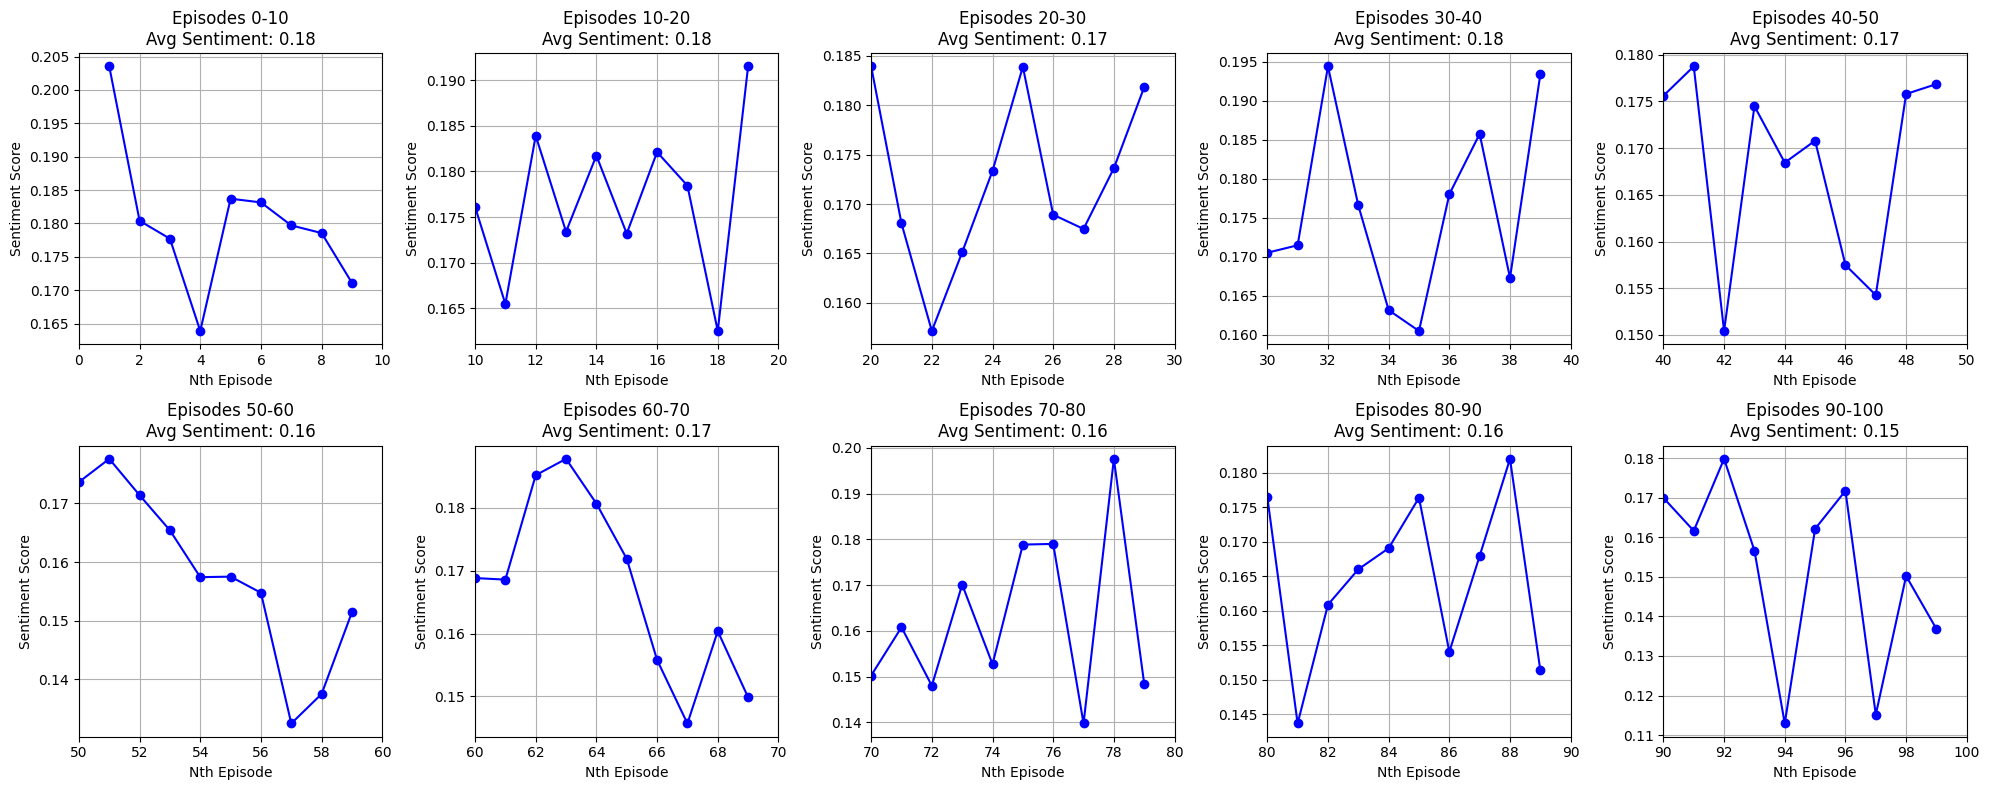

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the number of subplots and the range for each subplot
num_subplots = 10  # Covering 0-100 in steps of 10
x_ranges = [(i * 10, (i + 1) * 10) for i in range(num_subplots)]

# Ensure continuity by reindexing the data
full_index = pd.RangeIndex(start=0, stop=100)
sentiment_by_episode = sentiment_by_episode.reindex(full_index, fill_value=None)

# Create a grid of subplots
rows = 2
cols = 5  # 2 rows and 5 columns for 10 graphs
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
axes = axes.flatten()

for ax, (start, end) in zip(axes, x_ranges):
    # Filter data for the current range
    interval_data = sentiment_by_episode[(sentiment_by_episode.index >= start) & (sentiment_by_episode.index < end)]

    # Calculate the average sentiment score for the interval
    avg_sentiment = interval_data.mean()

    # Plot the data, connecting gaps
    ax.plot(interval_data.index, interval_data.values, linestyle='-', marker='o', color='b')
    ax.set_xlim(start, end)
    #ax.set_ylim(0.1, 0.25)
    ax.set_title(f"Episodes {start}-{end}\nAvg Sentiment: {avg_sentiment:.2f}")
    ax.set_xlabel("Nth Episode")
    ax.set_ylabel("Sentiment Score")
    ax.grid()

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


As can be seen in above graphs, the average sentiment over the first 100 episodes does decline, even if ever so slightly. In the first 10 episodes, we have an average sentiment score of 0.18, this is down to 0.15 by episodes 90 - 100.

In [ ]:
# Reset the index so that "Nth Episode" is a column
sentiment_by_episode = sentiment_by_episode.reset_index()
sentiment_by_episode.columns = ['Nth Episode', 'Sentiment Score']  # Rename for clarity

# Drop rows where the Sentiment Score is NaN
clean_data = sentiment_by_episode.dropna(subset=['Sentiment Score'])

# Calculate Pearson correlation
correlation, p_value = pearsonr(clean_data['Nth Episode'], clean_data['Sentiment Score'])

print(f"Correlation: {correlation}")
print(f"P-value: {p_value}")

Correlation: -0.47950095957443956
P-value: 5.128176106109908e-07


We see quite a large correlation (Pearson R) for the number of N episodes and the sentiment score. The P-value evidences statistical significance.

We will now look at genres and their sentiment scores.

**Sentiment by genre**

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


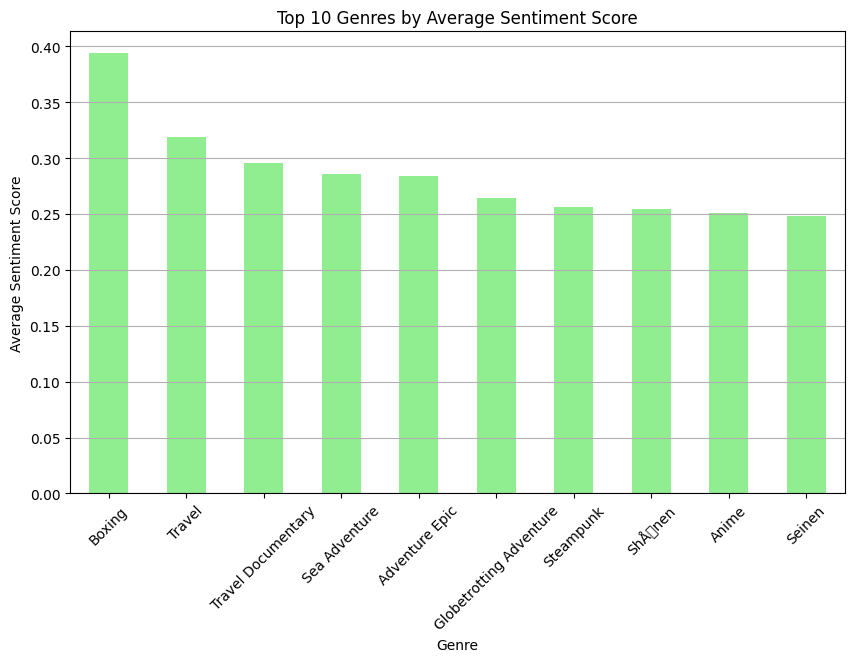

Top Genres by Average Sentiment Score:
Genres
Boxing                     0.393678
Travel                     0.319196
Travel Documentary         0.295318
Sea Adventure              0.285897
Adventure Epic             0.284172
Globetrotting Adventure    0.264617
Steampunk                  0.256343
ShÅnen                    0.254818
Anime                      0.251029
Seinen                     0.248595
Name: Sentiment Score, dtype: float64


In [ ]:
# Explode the genres column to associate each genre with its sentiment score
genres_with_scores = df[['Genres', 'Sentiment Score']].dropna()
genres_with_scores['Genres'] = genres_with_scores['Genres'].str.split(', ')
exploded_genres_scores = genres_with_scores.explode('Genres')

# Calculate the average sentiment score for each genre
avg_sentiment_by_genre = exploded_genres_scores.groupby('Genres')['Sentiment Score'].mean().sort_values(ascending=False)

# Plot the top 10 genres with the highest sentiment scores
plt.figure(figsize=(10, 6))
avg_sentiment_by_genre.head(10).plot(kind='bar', color='lightgreen')
plt.title('Top 10 Genres by Average Sentiment Score')
plt.xlabel('Genre')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Print the top genres by sentiment score for reference
print("Top Genres by Average Sentiment Score:")
print(avg_sentiment_by_genre.head(10))


In [ ]:
def find_shows_by_genre(df, genre):
    """
    Finds all unique shows that belong to a specified genre and the number of reviews for each show.

    Parameters:
        df (pd.DataFrame): The dataset containing TV shows and their genres.
        genre (str): The genre to search for.

    Returns:
        pd.DataFrame: A DataFrame with TV show names and their corresponding review counts.
    """
    # Filter the DataFrame for rows where 'Genres' contains the specified genre
    filtered_df = df[df['Genres'].str.contains(genre, case=False, na=False)]

    # Group by TV Show and count the number of reviews and episodes
    show_review_counts = filtered_df['TV Show'].value_counts().reset_index()
    # add total number of episodes to df too
    show_review_counts = show_review_counts.merge(df.groupby('TV Show')['Nth Episode'].max().reset_index(), on='TV Show')
    show_review_counts.columns = ['TV Show', 'Review Count', 'Total Episodes']

    return show_review_counts

genre_to_search = "Boxing"
shows_in_genre = find_shows_by_genre(df, genre_to_search)

print(f"Shows with '{genre_to_search}' as a genre:")
print(shows_in_genre)

Shows with 'Boxing' as a genre:
                TV Show  Review Count  Total Episodes
0  160. Fighting Spirit             3              75


Boxing appears to be the genre with the highest sentiment scores, however, looking into it, the only show with this genre is Fighting Spirit. Additionally, this show only has 3 reviews...

In [ ]:
genre_to_search = "Travel"
shows_in_genre = find_shows_by_genre(df, genre_to_search)

print(f"Shows with '{genre_to_search}' as a genre:")
print(shows_in_genre)

Shows with 'Travel' as a genre:
              TV Show  Review Count  Total Episodes
0     238. Doctor Who          3438             175
1  17. Rick and Morty          1172              71
2            93. Dark           446              26
3   206. Samurai Jack           117              62
4     90. Steins;Gate            72              25
5    31. Human Planet             9               8
6       122. Top Gear             3              66


In [ ]:
import matplotlib.pyplot as plt
import math

def plot_sentiment_by_genre(df, genre, max_subplots):
    """
    Plots sentiment analysis graphs for a specific genre.

    Parameters:
        df (pd.DataFrame): The dataset containing the reviews.
        genre (str): The genre to filter by.
        max_subplots (int): Maximum number of subplots to divide the episode range into.
    """
    # Filter the dataset for the specific genre
    genre_filtered_df = df[df['Genres'].str.contains(genre, case=False, na=False)]

    # Calculate sentiment scores grouped by episode number
    sentiment_by_episode = genre_filtered_df.groupby('Nth Episode')['Sentiment Score'].mean()

    # Determine the actual number of episodes for the genre
    num_episodes = len(sentiment_by_episode)
    if num_episodes == 0:
        print(f"No episodes found for the genre: {genre}")
        return

    # Dynamically adjust the number of subplots based on the number of episodes
    num_subplots = min(max_subplots, math.ceil(num_episodes / 10))  # Assuming ~10 episodes per subplot

    # Define the range for each subplot
    episodes_per_subplot = math.ceil(num_episodes / num_subplots)
    x_ranges = [(i * episodes_per_subplot, min((i + 1) * episodes_per_subplot, num_episodes)) for i in range(num_subplots)]

    # Create a grid of subplots
    rows = (num_subplots + 2) // 3  # Determine number of rows based on subplots
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()[:num_subplots]

    for ax, (start, end) in zip(axes, x_ranges):
        # Filter data for the current range
        interval_data = sentiment_by_episode.iloc[start:end]

        # Calculate the average sentiment score for the interval
        avg_sentiment = interval_data.mean() if not interval_data.empty else float('nan')

        # Plot the data
        ax.plot(interval_data.index, interval_data.values, linestyle='-', color='b')
        ax.set_xlim(start, end - 1)
        ax.set_ylim(sentiment_by_episode.min() - 0.1, sentiment_by_episode.max() + 0.1)
        ax.set_title(f"Episodes {start + 1}-{end}\nAvg Sentiment: {avg_sentiment:.2f}")
        ax.set_xlabel("Nth Episode")
        ax.set_ylabel("Sentiment Score")
        ax.grid()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.suptitle(f"Sentiment Analysis for Genre: {genre}", y=1.02, fontsize=16)  # Add a super title
    plt.show()

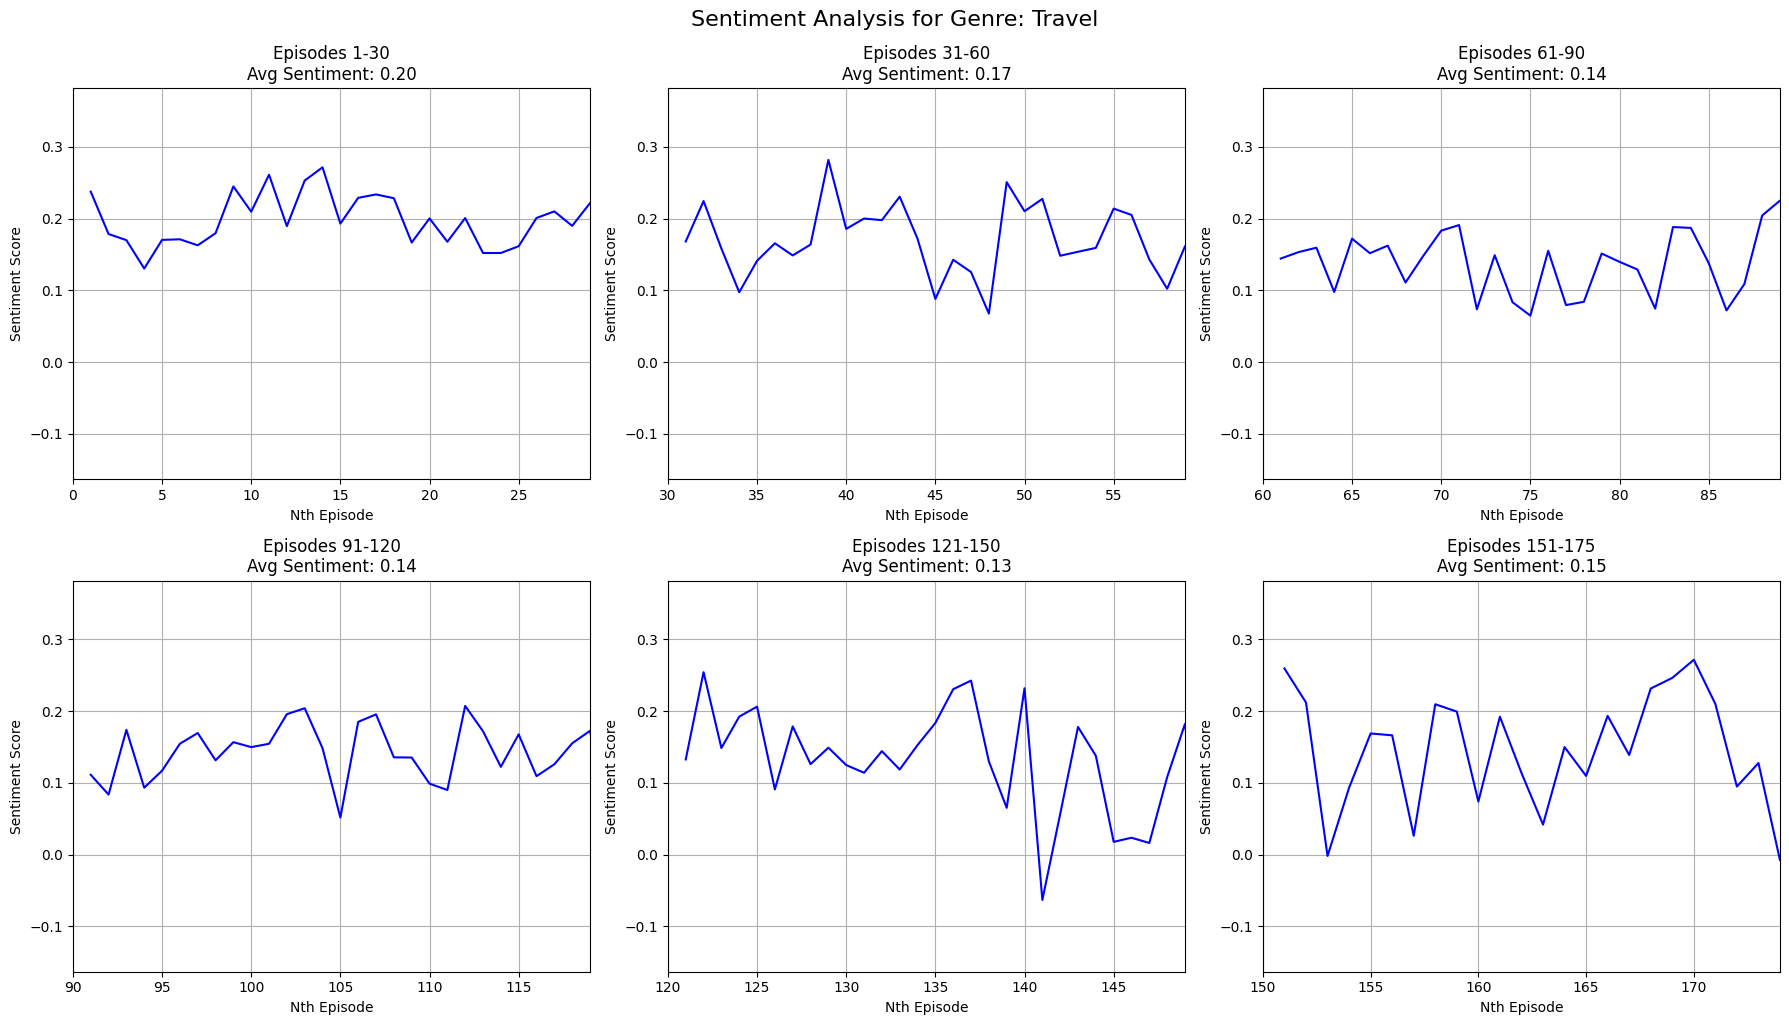

In [ ]:
plot_sentiment_by_genre(df, 'Travel', max_subplots=6)

In [ ]:
# Print the top genres by sentiment score for reference
print("Worst Genres by Average Sentiment Score:")
print(avg_sentiment_by_genre.tail(10))

Worst Genres by Average Sentiment Score:
Genres
Suspense Mystery           0.128628
Western Epic               0.128551
Conspiracy Thriller        0.128515
News                       0.125168
Contemporary Western       0.118614
Artificial Intelligence    0.111739
Stoner Comedy              0.102949
Military Documentary       0.092759
History Documentary        0.092759
Crime Documentary         -0.013003
Name: Sentiment Score, dtype: float64


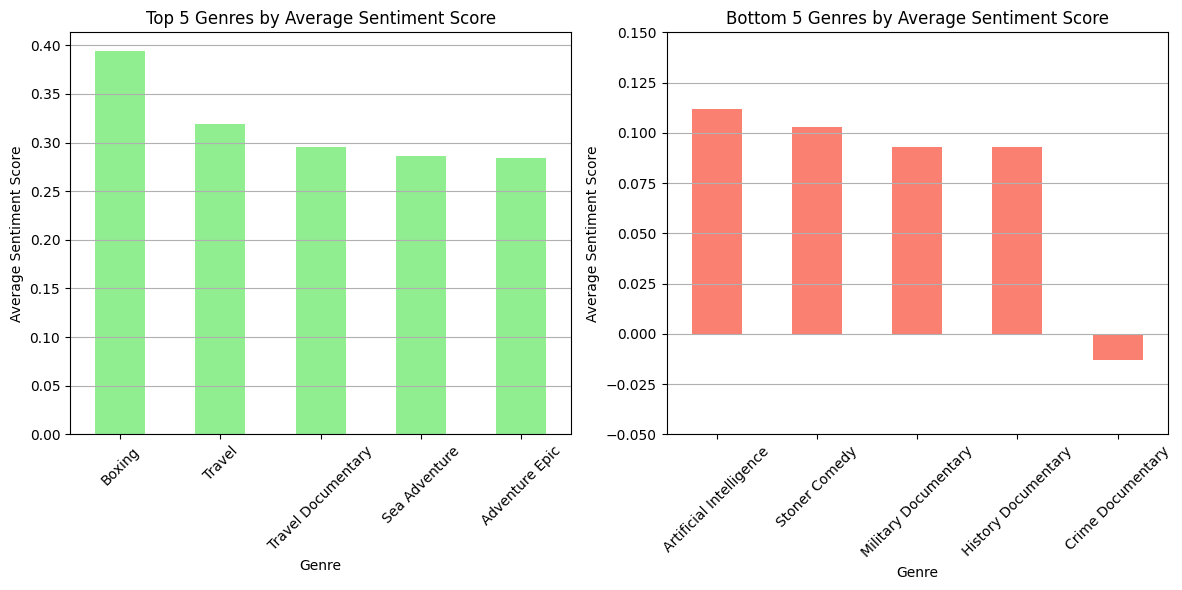

Top 5 Genres by Average Sentiment Score:
Genres
Boxing                0.393678
Travel                0.319196
Travel Documentary    0.295318
Sea Adventure         0.285897
Adventure Epic        0.284172
Name: Sentiment Score, dtype: float64

Bottom 5 Genres by Average Sentiment Score:
Genres
Artificial Intelligence    0.111739
Stoner Comedy              0.102949
Military Documentary       0.092759
History Documentary        0.092759
Crime Documentary         -0.013003
Name: Sentiment Score, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Plot the top 5 genres with the highest sentiment scores
plt.figure(figsize=(12, 6))

# Subplot for top 5 genres
plt.subplot(1, 2, 1)
avg_sentiment_by_genre.head(5).plot(kind='bar', color='lightgreen')
plt.title('Top 5 Genres by Average Sentiment Score')
plt.xlabel('Genre')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Subplot for bottom 5 genres
plt.subplot(1, 2, 2)
avg_sentiment_by_genre.tail(5).plot(kind='bar', color='salmon')
plt.title('Bottom 5 Genres by Average Sentiment Score')
plt.xlabel('Genre')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
min_value = avg_sentiment_by_genre.tail(5).min()
plt.ylim(-0.05,0.15)  # Add padding below the minimum value

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print the top and bottom genres by sentiment score for reference
print("Top 5 Genres by Average Sentiment Score:")
print(avg_sentiment_by_genre.head(5))
print("\nBottom 5 Genres by Average Sentiment Score:")
print(avg_sentiment_by_genre.tail(5))


In [ ]:
genre_to_search = "Crime Documentary"
shows_in_genre = find_shows_by_genre(df, genre_to_search)

print(f"Shows with '{genre_to_search}' as a genre:")
print(shows_in_genre)

Shows with 'Crime Documentary' as a genre:
                                             TV Show  Review Count  \
0                             199. Making a Murderer            40   
1  154. The Jinx: The Life and Deaths of Robert D...             6   

   Total Episodes  
0              20  
1               6  


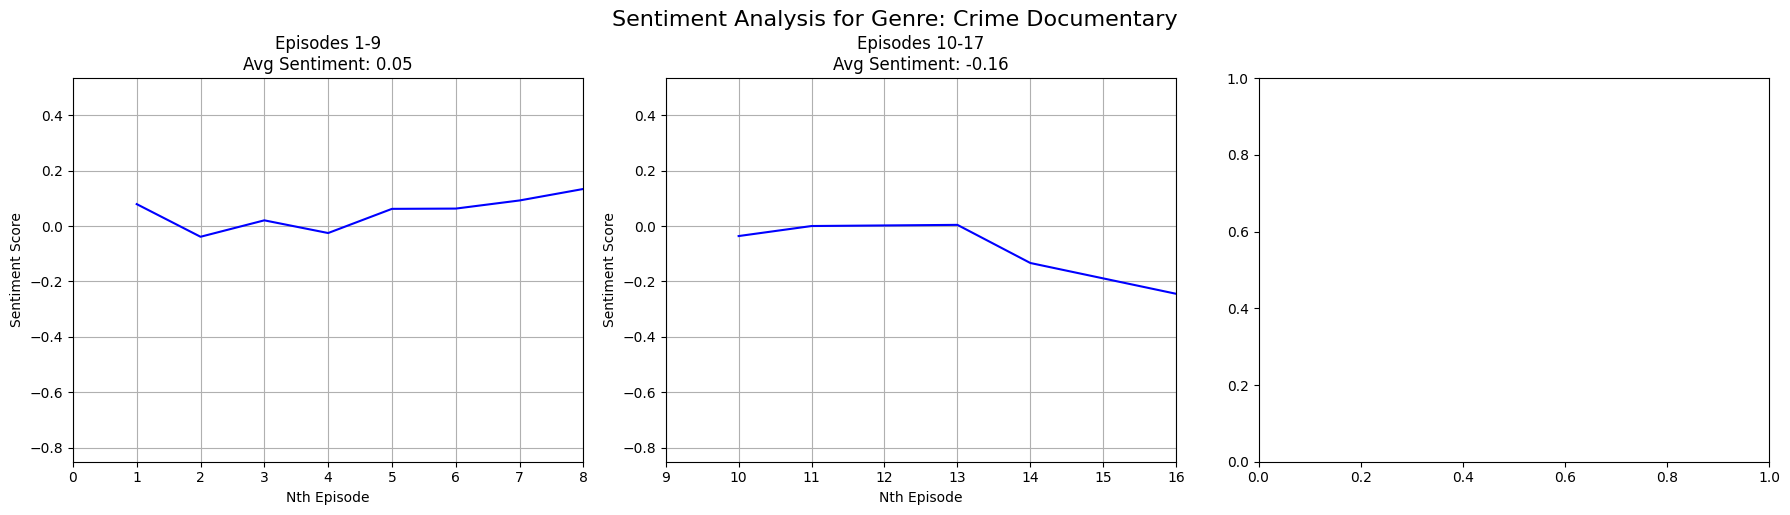

In [ ]:
plot_sentiment_by_genre(df, 'Crime Documentary', max_subplots=2)

In [ ]:
genre_to_search = "History Documentary"
shows_in_genre = find_shows_by_genre(df, genre_to_search)

print(f"Shows with '{genre_to_search}' as a genre:")
print(shows_in_genre)

Shows with 'History Documentary' as a genre:
                                  TV Show  Review Count  Total Episodes
0                    15. The World at War            47              26
1                     21. The Vietnam War            43              10
2                       37. The Civil War            27               9
3  166. Greatest Events of WWII in Colour            17              10
4    48. Apocalypse: The Second World War             1               6


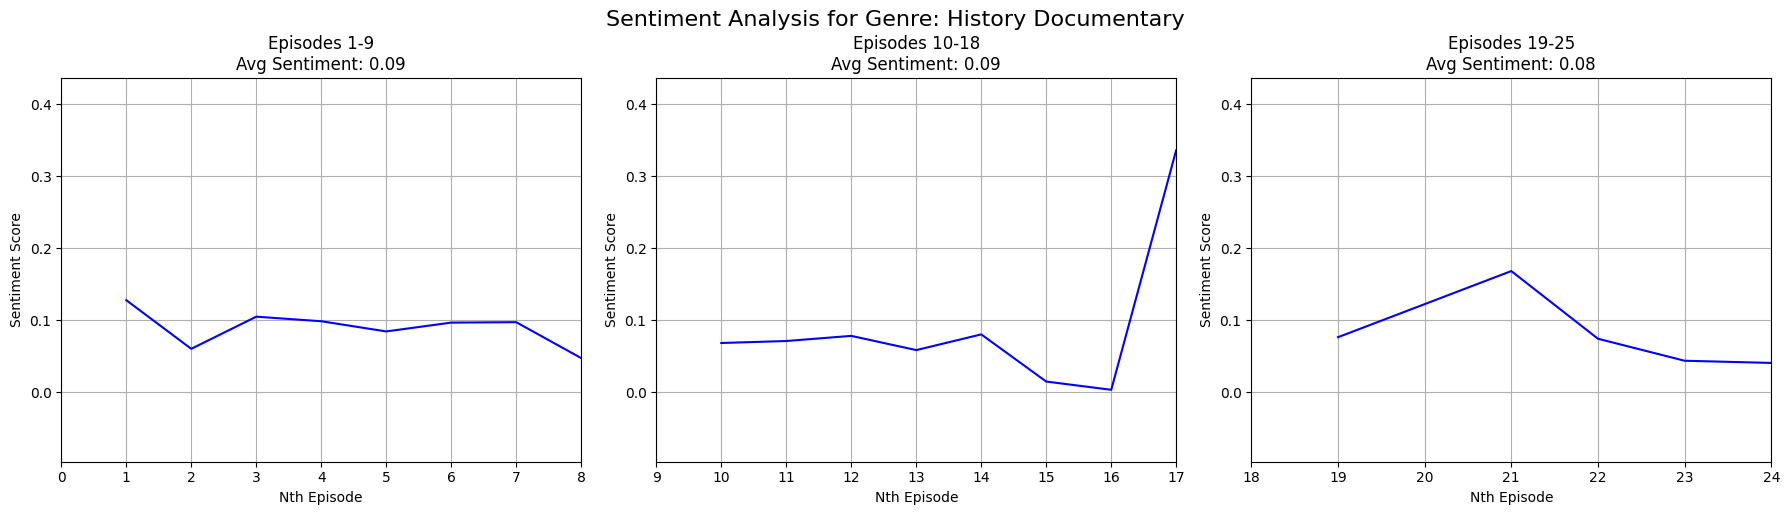

In [ ]:
plot_sentiment_by_genre(df, 'History Documentary', max_subplots=6)

Interestingly, these are darker themes. The darker themes come across in the user reviews: "The year 1864 marks the fourth year of this horrible war. Pictures sent depicting some of it are so horrendous people can't look at them. They show one here, and you'd swear this was a photo of someone in a concentration camp in World War II. The man was nothing but skin and bones. Horrifying. The more was learns of the Civil War, the worse it gets.Grant now had command of the largest army in the world. His rank had grown to "Lt. General," the first since George Washington. We get a profile of his amazing rise from loser in society to the leader of the North military. Then we get a profile of the most military leader of the them all: General Robert E Lee of the South.Most of this installment of the series is about Grant and Lee, and their battles to two had up and down Virginia. Then, after a very depressing segment about all the men suffering in the ever-growing number of hospitals, we get another profile of an important man in this war: General Sherman. With Grant stalled at Petersburg, Grant had to win in Tennessee and Georgia. Abe Lincoln predicts he will lose the election, perhaps by a landslide."

So many negative words, obviously make for a negative sentiment. However, not towards the show..

In [ ]:
import numpy as np
from scipy.stats import linregress

# Create a copy of the Genres column for processing
df['Genres Copy'] = df['Genres'].str.split(', ')

# Filter genres with at least 50 episodes
genre_episode_counts = df.explode('Genres Copy').groupby('Genres Copy')['Nth Episode'].count()
valid_genres = genre_episode_counts[genre_episode_counts >= 50].index

# Analyze sentiment trends for valid genres
genre_trends = []

for genre in valid_genres:
    genre_df = df[df['Genres Copy'].apply(lambda x: genre in x)]
    sentiment_by_episode = genre_df.groupby('Nth Episode')['Sentiment Score'].mean().reset_index()

    # Fit a linear trend
    if len(sentiment_by_episode) > 1:  # Ensure there are enough points for a trend
        slope, intercept, r_value, p_value, std_err = linregress(
            sentiment_by_episode['Nth Episode'], sentiment_by_episode['Sentiment Score']
        )
        genre_trends.append((genre, slope, r_value, p_value))

# Sort genres by slope (decline in sentiment)
genre_trends = sorted(genre_trends, key=lambda x: x[1])  # Sort by slope (ascending)
declining_genres = [g for g in genre_trends if g[1] < 0]

# Display genres with the steepest decline
print("Genres with the steepest decline in sentiment:")
for genre, slope, r_value, p_value in declining_genres[:10]:  # Top 10 declines
    print(f"Genre: {genre}, Slope: {slope:.4f}, R²: {r_value**2:.4f}, p-value: {p_value:.4g}")

# Remove the temporary Genres Copy column to restore the original DataFrame
df.drop(columns=['Genres Copy'], inplace=True)



Genres with the steepest decline in sentiment:
Genre: Dinosaur Adventure, Slope: -0.0122, R²: 0.2210, p-value: 0.03646
Genre: Zombie Horror, Slope: -0.0071, R²: 0.2649, p-value: 0.1562
Genre: True Crime, Slope: -0.0054, R²: 0.1547, p-value: 0.03482
Genre: Computer Animation, Slope: -0.0051, R²: 0.2729, p-value: 0.02615
Genre: Kaiju, Slope: -0.0049, R²: 0.0571, p-value: 0.2399
Genre: Docudrama, Slope: -0.0046, R²: 0.2039, p-value: 0.01225
Genre: Cyberpunk, Slope: -0.0035, R²: 0.0806, p-value: 0.1599
Genre: Soccer, Slope: -0.0028, R²: 0.1821, p-value: 0.01185
Genre: War, Slope: -0.0025, R²: 0.5722, p-value: 1.328e-06
Genre: War Epic, Slope: -0.0025, R²: 0.0966, p-value: 0.3821


In [ ]:
genre_to_search = "True Crime"
shows_in_genre = find_shows_by_genre(df, genre_to_search)

print(f"Shows with '{genre_to_search}' as a genre:")
print(shows_in_genre)

Shows with 'True Crime' as a genre:
                                             TV Show  Review Count  \
0                                         75. Narcos           138   
1                               51. When They See Us            55   
2                             199. Making a Murderer            40   
3             30. Scam 1992: The Harshad Mehta Story            39   
4  154. The Jinx: The Life and Deaths of Robert D...             6   

   Total Episodes  
0              30  
1               4  
2              20  
3              10  
4               6  


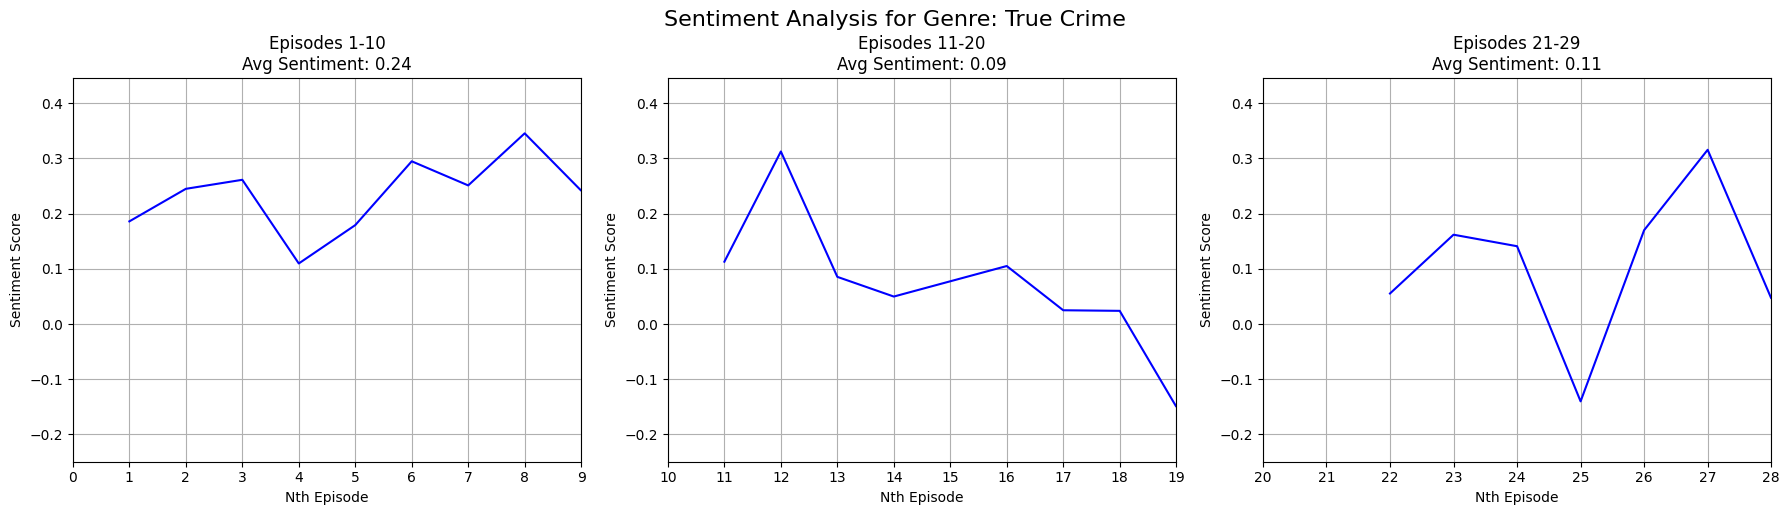

In [ ]:
plot_sentiment_by_genre(df, 'True Crime', max_subplots=6)

For True Crime, we see in particular a decline after episode 12 . It would be interesting to see the reason for this decline. While it is no definitive decline, since Narcos still seems to be able to have some episodes with better average sentiment scores, the genre definitely does not seem to get as appreciative reviews as in the beginning of the shows. We may be able to look at this, doing topic modelling.

# **Topic Modelling**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import re
import nltk


def preprocess_text(text, use_stemming=False, use_lemmatization=True):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize text into words
    words = text.split()

    if use_stemming:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    elif use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    # Recombine words into a single string
    return ' '.join(words)

def perform_topic_modeling(reviews, num_topics=5, num_words=10):
    vectorizer = TfidfVectorizer(
          stop_words='english',  # Remove common stop words
          max_df=0.9,            # Ignore very frequent terms
          min_df=5               # Include terms appearing in at least 5 reviews
      )

    reviews = reviews.apply(lambda x: preprocess_text(x, False, True))
    dtm = vectorizer.fit_transform(reviews)

    # Step 5: Apply LDA for Topic Modeling
    num_topics = 3  # Number of topics to extract
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)

    topics = {}
    for idx, topic in enumerate(lda.components_):
        topics[f'Topic {idx + 1}'] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-num_words:]]
    return topics

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def perform_topic_modeling_phrases(reviews, num_topics=5, num_words=5):
    vectorizer = TfidfVectorizer(
          stop_words='english',  # Remove common stop words
          max_df=0.9,            # Ignore very frequent terms
          min_df=5,               # Include terms appearing in at least 5 reviews
          ngram_range=(3, 3)
        )

    reviews = reviews.apply(lambda x: preprocess_text(x, False, True))
    dtm = vectorizer.fit_transform(reviews)

    # Step 5: Apply LDA for Topic Modeling
    num_topics = 3  # Number of topics to extract
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(dtm)

    topics = {}
    for idx, topic in enumerate(lda.components_):
        topics[f'Topic {idx + 1}'] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-num_words:]]
    return topics

Let's zoom into the decline on "True Crime": what stands out for the episodes? What plot lines do we come across at this point? And how do those differ from before?

In [ ]:
# Step 1: Filter Data for the 'True Crime' Genre
true_crime_episodes = df[df['Genres'].str.contains('True Crime', case=False, na=False)]

# Convert the 'Nth Episode' column to numeric for filtering past episode 11
true_crime_episodes['Nth Episode'] = pd.to_numeric(true_crime_episodes['Nth Episode'], errors='coerce')

# Split data into two groups
true_crime_up_to_11 = true_crime_episodes[true_crime_episodes['Nth Episode'] <= 11]
true_crime_after_11 = true_crime_episodes[true_crime_episodes['Nth Episode'] > 11]

<ipython-input-44-e54ca8912ae1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_crime_episodes['Nth Episode'] = pd.to_numeric(true_crime_episodes['Nth Episode'], errors='coerce')


In [ ]:
# Step 3: Perform Topic Modeling for Both Groups
topics_up_to_11 = perform_topic_modeling(
    true_crime_up_to_11['Episode Description'].dropna()
)

topics_after_11 = perform_topic_modeling(
    true_crime_after_11['Episode Description'].dropna()
)

In [ ]:
# Step 4: Display Topics for Comparison
print("Topics for 'True Crime' episodes up to episode 11:")
for topic, words in topics_up_to_11.items():
    print(f"{topic}: {', '.join(words)}")

print("\nTopics for 'True Crime' episodes after episode 11:")
for topic, words in topics_after_11.items():
    print(f"{topic}: {', '.join(words)}")

Topics for 'True Crime' episodes up to episode 11:
Topic 1: ignored, really, real, light, event, korey, happened, prison, truth, come
Topic 2: jury, drug, durst, stevens, steve, fight, new, police, conflicting, pablo
Topic 3: accused, brutal, central, rape, falsely, park, female, jogger, teenager, crime

Topics for 'True Crime' episodes after episode 11:
Topic 1: mission, don, tata, pablo, steve, president, pea, help, danger, new
Topic 2: sought, corruption, colombian, suspicion, shocked, new, pablo, miguel, child, kathleen
Topic 3: decision, associate, gentleman, surprise, big, announcement, gather, make, cali, future


In [ ]:
# Step 3: Perform Topic Modeling for Both Groups
topic_phrases_up_to_11 = perform_topic_modeling_phrases(
    true_crime_up_to_11['Episode Description'].dropna()
)

topic_phrases_after_11 = perform_topic_modeling_phrases(
    true_crime_after_11['Episode Description'].dropna()
)

In [ ]:
# Step 4: Display Topics for Comparison
print("Topics for 'True Crime' episodes up to episode 11:")
for topic, words in topic_phrases_up_to_11.items():
    print(f"{topic}: {', '.join(words)}")

print("\nTopics for 'True Crime' episodes after episode 11:")
for topic, words in topic_phrases_after_11.items():
    print(f"{topic}: {', '.join(words)}")

Topics for 'True Crime' episodes up to episode 11:
Topic 1: come really happened, really happened event, real truth come, finally come light, happened event ignored
Topic 2: falsely accused crime, female jogger central, rape assault female, central park africanamerican, law enforcement official
Topic 3: soon bag sbi, fate turn watch, fancy launch cartel, broker start dealing, cartel broker start

Topics for 'True Crime' episodes after episode 11:
Topic 1: leader gilberto rodriguez, pea hatch plan, proposes business idea, cali leader gilberto, gilberto rodriguez amado
Topic 2: associate big surprise, surprise announcement future, cali gather associate, gather associate big, gentleman cali gather
Topic 3: pablo surrender sake, javier deal repercussion, try convince pablo, judys interview tata, deal repercussion judys


Let's zoom out again, looking at the general best and worst genres as for the sentiment scores. What are reoccuring themes in the reviews people leave for episodes of these genres?

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Identify the 5 Worst/Best Genres Using Precomputed Data
worst_genres = avg_sentiment_by_genre.tail(5).index.tolist()
best_genres = avg_sentiment_by_genre.head(5).index.tolist()
print(f"The 5 best genres are: {best_genres}")
print(f"The 5 worst genres are: {worst_genres}")


# Step 2: Iterate Over Each Genre
def topic_modelling_genres(df, genres):
  for genre in genres:
      print(f"\nTopic Modeling for Genre: {genre}")

      # Step 3: Filter Reviews for the Genre
      filtered_reviews = df[df['Genres'].str.contains(genre, case=False, na=False)]['User Review'].dropna()

      if filtered_reviews.empty or len(filtered_reviews) < 5:
          print(f"No or not enough reviews found for genre: {genre}")
          continue

      preprocessed_reviews = filtered_reviews.apply(lambda x: preprocess_text(x, False, True))

      vectorizer = TfidfVectorizer(
          stop_words='english',  # Remove common stop words
          max_df=0.9,            # Ignore very frequent terms
          min_df=5               # Include terms appearing in at least 5 reviews
      )
      dtm = vectorizer.fit_transform(preprocessed_reviews)

      # Step 5: Apply LDA for Topic Modeling
      num_topics = 3  # Number of topics to extract
      lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
      lda.fit(dtm)

      # Step 6: Display the Top Words for Each Topic
      print(f"\nTop {num_topics} Topics for {genre}:")
      for idx, topic in enumerate(lda.components_):
          top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]  # Top 10 words
          print(f"Topic {idx + 1}: {', '.join(top_words)}")



The 5 best genres are: ['Boxing', 'Travel', 'Travel Documentary', 'Sea Adventure', 'Adventure Epic']
The 5 worst genres are: ['Artificial Intelligence', 'Stoner Comedy', 'Military Documentary', 'History Documentary', 'Crime Documentary']


In [ ]:
topic_modelling_genres(df, best_genres)


Topic Modeling for Genre: Boxing
No or not enough reviews found for genre: Boxing

Topic Modeling for Genre: Travel

Top 3 Topics for Travel:
Topic 1: upper, et, abomination, hunted, suzuha, mayuri, la, le, okabe, kurisu
Topic 2: great, really, funny, like, just, wa, season, morty, episode, rick
Topic 3: like, just, series, good, ha, time, story, wa, episode, doctor

Topic Modeling for Genre: Travel Documentary

Top 3 Topics for Travel Documentary:
Topic 1: graceful, gorgeous, fresh, fluid, fallen, fact, hugely, year, comprehensively, huge
Topic 2: exceptionally, attenborough, hurt, attenboroughs, huge, episode, planet, environment, way, human
Topic 3: graceful, gorgeous, fresh, fluid, fallen, fact, hugely, year, comprehensively, huge

Topic Modeling for Genre: Sea Adventure

Top 3 Topics for Sea Adventure:
Topic 1: really, anime, good, like, just, luffy, piece, animation, wa, episode
Topic 2: character, love, wait, animation, amazing, great, wa, piece, best, episode
Topic 3: chopper,

In [ ]:
topic_modelling_genres(df, worst_genres)


Topic Modeling for Genre: Artificial Intelligence

Top 3 Topics for Artificial Intelligence:
Topic 1: business, just, episode, ship, dont, outside, hate, reminds, politician, fix
Topic 2: hate, politician, reminds, dispute, outside, hallucination, goosebump, fix, business, consistently
Topic 3: adama, cylon, just, character, series, season, cylons, ha, wa, episode

Topic Modeling for Genre: Stoner Comedy

Top 3 Topics for Stoner Comedy:
Topic 1: best, watch, hilarious, fun, series, strong, episode, just, dog, classic
Topic 2: season, ray, boy, trailer, park, randy, bubble, lahey, julian, ricky
Topic 3: hilarious, kind, best, scene, moment, tpb, episode, like, series, great

Topic Modeling for Genre: Military Documentary

Top 3 Topics for Military Documentary:
Topic 1: british, hitler, south, american, world, vietnam, episode, german, war, wa
Topic 2: history, invasion, polish, word, division, won, editing, score, total, sound
Topic 3: british, open, editing, score, total, sound, word,

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def topic_modelling_phrases_genres(df, genres):
    for genre in genres:
        print(f"\nTopic Modeling for Genre: {genre}")

        # Step 3: Filter Reviews for the Genre
        filtered_reviews = df[df['Genres'].str.contains(genre, case=False, na=False)]['User Review'].dropna()

        if filtered_reviews.empty or len(filtered_reviews) < 5:
            print(f"No or not enough reviews found for genre: {genre}")
            continue

        preprocessed_reviews = filtered_reviews.apply(lambda x: preprocess_text(x, False, True))

        # Step 5: Vectorize with Trigrams (3-word sequences)
        vectorizer = TfidfVectorizer(
            stop_words='english',          # Remove common stop words
            max_df=0.95,                    # Ignore very frequent terms
            min_df=3,                      # Include terms appearing in at least 5 reviews
            ngram_range=(3, 3)             # Extract trigrams (3-word sequences)
        )
        dtm = vectorizer.fit_transform(preprocessed_reviews)

        # Step 6: Apply LDA for Topic Modeling
        num_topics = 3  # Number of topics to extract
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(dtm)

        # Step 7: Display the Top Trigrams for Each Topic
        print(f"\nTop {num_topics} Topics for {genre}:")
        for idx, topic in enumerate(lda.components_):
            top_trigrams = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]  # Top 10 trigrams
            print(f"Topic {idx + 1}: {', '.join(top_trigrams)}")


In [ ]:
topic_modelling_phrases_genres(df, best_genres)


Topic Modeling for Genre: Boxing
No or not enough reviews found for genre: Boxing

Topic Modeling for Genre: Travel

Top 3 Topics for Travel:
Topic 1: doesnt make sense, wa great episode, wa really good, rating series episode, felt like wa, episode wa great, series episode ranking, season rick morty, episode rick morty, best episode series
Topic 2: rick morty ha, doe great job, really good episode, best episode season, deus ex machina, episode feel like, wa good episode, episode wa good, rick morty episode, doctor amy rory
Topic 3: doctor matt smith, sarah jane smith, sarah jane adventure, doctor rose jack, didnt feel like, classic rick morty, captain jack harkness, wa best episode, episode ive seen, like rick morty

Topic Modeling for Genre: Travel Documentary

Top 3 Topics for Travel Documentary:
Topic 1: fact output david, feel fresh come, episode concept settingwise, comprehensively feel like, teaching sincerely comprehensively, sincerely comprehensively feel, couldntbeanybetter e

In [ ]:
topic_modelling_phrases_genres(df, worst_genres)


Topic Modeling for Genre: Artificial Intelligence

Top 3 Topics for Artificial Intelligence:
Topic 1: battlestar galactica ha, cylons look human, episode series far, science fiction best, pilot episode wa, vote eighttitle brazil, make matter worse, president laura roslin, series battlestar galactica, edward james olmos
Topic 2: wa great episode, love battlestar galactica, battlestar galactica wa, cheesy guitar music, episode look like, dr gaius baltar, acting wa solid, season battlestar galactica, cylon base star, ha happened happen
Topic 3: episode resurrection ship, like real life, wa fine episode, episode wa best, episode entire series, episode season great, cylon civil war, wa good episode, adama president roslin, president roslin ha

Topic Modeling for Genre: Stoner Comedy

Top 3 Topics for Stoner Comedy:
Topic 1: start fighting lahey, bubble cory trevor, ricky trailer park, park boy episode, julian tell ricky, police come arrest, assistant trailer park, ricky make deal, park sup

Let's zoom out even more, and look at all the genres together. Is there a temporal difference in the user reviews as to topics coming across in reviews?

In [ ]:
# Analyze by episode ranges
episode_ranges = [(1, 20), (21, 40), (41, 60), (61, 80), (81, 100)]
for start, end in episode_ranges:
    reviews = df[(df['Nth Episode'] >= start) & (df['Nth Episode'] <= end)]['User Review'].dropna()
    topics = perform_topic_modeling(reviews)
    print(f'\nTopics for Episodes {start}-{end}:')
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")


Topics for Episodes 1-20:
Topic 1: amazing, ha, great, rose, jimmy, tony, doctor, dexter, wa, episode
Topic 2: series, really, great, good, like, just, character, season, wa, episode
Topic 3: michael, mulder, war, man, episode, sherlock, wa, ha, poirot, holmes

Topics for Episodes 21-40:
Topic 1: ha, really, best, like, great, just, character, season, wa, episode
Topic 2: ha, diana, charles, queen, picard, enterprise, ship, data, batman, dexter
Topic 3: character, great, really, good, season, just, like, ha, episode, wa

Topics for Episodes 41-60:
Topic 1: poirot, character, good, time, story, like, doctor, ha, wa, episode
Topic 2: trinity, royal, crown, queen, homer, lumen, charles, diana, tony, dexter
Topic 3: ha, great, really, best, character, like, just, season, wa, episode

Topics for Episodes 61-80:
Topic 1: really, good, like, character, great, best, just, season, wa, episode
Topic 2: good, really, time, character, season, just, like, ha, wa, episode
Topic 3: throne, marie, ce

In [ ]:
# Analyze by episode ranges
episode_ranges = [(1, 20), (21, 40), (41, 60), (61, 80), (81, 100)]
for start, end in episode_ranges:
    reviews = df[(df['Nth Episode'] >= start) & (df['Nth Episode'] <= end)]['User Review'].dropna()
    topics = perform_topic_modeling_phrases(reviews)
    print(f'\nTopics for Episodes {start}-{end}:')
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")


Topics for Episodes 1-20:
Topic 1: previous episode wa, best episode season, ice truck killer, episode feel like, episode wa good
Topic 2: episode ive seen, wa pretty good, episode wa great, best episode far, wa great episode
Topic 3: did great job, episode black mirror, episode wa just, doe great job, best episode series

Topics for Episodes 21-40:
Topic 1: episode wa best, felt like wa, twilight zone episode, episode wa just, episode wa great
Topic 2: best episode far, best episode season, wa great episode, best episode series, episode wa good
Topic 3: best episode season, episode twilight zone, doesnt make sense, wa really good, episode felt like

Topics for Episodes 41-60:
Topic 1: doe great job, episode season wa, episode wa really, episode feel like, best episode series
Topic 2: really good episode, wa pretty good, wa good episode, episode wa great, best episode season
Topic 3: wa great episode, episode entire series, vote eighttitle brazil, episode twilight zone, twilight zone 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Step 1: Calculate Average Sentiment Scores for Each Episode
avg_sentiment_per_episode = (
    df.groupby(['TV Show', 'Season', 'Episode Title'], as_index=False)
      .agg({
          'Sentiment Score': 'mean',  # Average sentiment for the episode
          'Avg Episode Rating': 'first',  # Keep the avg episode rating column
          'Episode Description': 'first'  # Keep episode description for topic modeling
      })
)

# Sort data by show and episode for proper differencing
avg_sentiment_per_episode.sort_values(
    ['TV Show', 'Season', 'Episode Title'], inplace=True
)

# Step 2: Calculate Changes in Sentiment and User Ratings
avg_sentiment_per_episode['Sentiment Change'] = (
    avg_sentiment_per_episode.groupby('TV Show')['Sentiment Score'].diff()
)
avg_sentiment_per_episode['Rating Change'] = (
    avg_sentiment_per_episode.groupby('TV Show')['Avg Episode Rating'].diff()
)

# Step 3: Define Decline Thresholds
sentiment_decline_threshold = avg_sentiment_per_episode['Sentiment Change'].quantile(0.1)
rating_decline_threshold = avg_sentiment_per_episode['Rating Change'].quantile(0.1)

# Step 4: Flag Episodes with Significant Declines
flagged_episodes = avg_sentiment_per_episode[
    (avg_sentiment_per_episode['Sentiment Change'] <= sentiment_decline_threshold) &
    (avg_sentiment_per_episode['Rating Change'] <= rating_decline_threshold)
]

# Extract descriptions of flagged episodes
flagged_descriptions = flagged_episodes['Episode Description'].dropna()

# Perform topic modeling
topics = perform_topic_modeling(flagged_descriptions)

# Display topics
print("Topics identified in episodes with significant sentiment and rating declines:")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

# Display flagged episodes
print("\nFlagged episodes with significant declines:")
print(flagged_episodes[['TV Show', 'Season', 'Episode Title', 'Sentiment Change', 'Rating Change']])


Topics identified in episodes with significant sentiment and rating declines:
Topic 1: stop, love, office, big, decides, king, andy, world, return, try
Topic 2: time, secret, power, way, help, face, friend, make, ha, attempt
Topic 3: plan, member, come, village, news, past, ha, house, family, new

Flagged episodes with significant declines:
                        TV Show  Season  \
114         101. The Grand Tour     3.0   
315           103. The Simpsons     9.0   
462           103. The Simpsons    15.0   
521           103. The Simpsons    18.0   
526           103. The Simpsons    18.0   
...                         ...     ...   
10282        88. Six Feet Under     2.0   
10304        88. Six Feet Under     4.0   
10331                  89. Rome     1.0   
10533               94. Berserk     1.0   
10758  99. Battlestar Galactica     4.0   

                                          Episode Title  Sentiment Change  \
114                           S3.E4  Pick Up, Put Downs        



Lastly we will validate the sentiment scores

# **Validation**

In [ ]:
# Sort reviews by sentiment score for extreme cases
sorted_reviews = df[['User Review', 'Sentiment Score']].sort_values(by='Sentiment Score')

# Print examples for the lowest, neutral, and highest scores
print("Lowest Sentiment Scores:")
print(sorted_reviews.head(5), "\n")

print("Neutral Sentiment Scores (close to 0):")
neutral_reviews = sorted_reviews[(sorted_reviews['Sentiment Score'] > -0.1) & (sorted_reviews['Sentiment Score'] < 0.1)].sample(5)
print(neutral_reviews, "\n")

print("Highest Sentiment Scores:")
print(sorted_reviews.tail(5))

Lowest Sentiment Scores:
                                             User Review  Sentiment Score
58577  ....hmmmm, I'm distracted by Anna Torv's awful...             -1.0
32338  Prepare to be preached to. That's the vibe I a...             -1.0
9322   If you have watched it once go and watch the b...             -1.0
13438  Some say this show is boring. These people are...             -1.0
14986  This is a front-runner for the prize of being ...             -1.0 

Neutral Sentiment Scores (close to 0):
                                             User Review  Sentiment Score
6164   This season so far has been hit or miss, and i...        -0.039087
7180   Each time I watch this episode it just blows m...         0.080583
1390   The episodes focuses on the role of doctors in...         0.074643
56250  Lithgow's performance as Churchill sharing his...         0.100000
69831  ... I am obsessed with Silicon Valley culture....        -0.027278 

Highest Sentiment Scores:
                  

In [ ]:
# Define sentiment ranges
ranges = [(round(i, 1), round(i + 0.1, 1)) for i in np.arange(-1.0, 1.0, 0.1)]

# Function to compute average user ratings for each range
sentiment_rating_comparison = []
for lower, upper in ranges:
    subset = df[(df['Sentiment Score'] >= lower) & (df['Sentiment Score'] < upper)]
    avg_rating = subset['User Rating'].mean()
    sentiment_rating_comparison.append((f"{lower:.1f} to {upper:.1f}", avg_rating))

# Convert results to a DataFrame for easier viewing
comparison_df = pd.DataFrame(sentiment_rating_comparison, columns=["Sentiment Range", "Average User Rating"])

# Print results
print(comparison_df)

   Sentiment Range  Average User Rating
0     -1.0 to -0.9             4.875000
1     -0.9 to -0.8             4.461538
2     -0.8 to -0.7             6.500000
3     -0.7 to -0.6             5.864407
4     -0.6 to -0.5             4.857143
5     -0.5 to -0.4             5.697778
6     -0.4 to -0.3             5.461165
7     -0.3 to -0.2             5.478750
8     -0.2 to -0.1             5.913974
9     -0.1 to -0.0             6.546163
10     -0.0 to 0.1             7.479227
11      0.1 to 0.2             8.157514
12      0.2 to 0.3             8.686094
13      0.3 to 0.4             8.986254
14      0.4 to 0.5             9.181790
15      0.5 to 0.6             9.314709
16      0.6 to 0.7             9.535539
17      0.7 to 0.8             9.516209
18      0.8 to 0.9             9.501887
19      0.9 to 1.0             9.670455


In [ ]:
# Drop rows where either 'User Rating' or 'Sentiment Score' is NaN
filtered_df = df.dropna(subset=['User Rating', 'Sentiment Score'])

# Calculate Pearson correlation
correlation, p_value = pearsonr(filtered_df['User Rating'], filtered_df['Sentiment Score'])

print(f"Correlation: {correlation}, P-value: {p_value}")

Correlation: 0.37862221858786127, P-value: 0.0


The sentiment scores and the user ratings seem well aligned.

In [ ]:
def rating_to_sentiment_class(rating):
    if rating >= 6:
        return 'positive'
    elif rating < 6:
        return 'negative'

# Apply to generate 'true' labels from user ratings
df_copy = df.copy().dropna(subset=['User Rating'])
df_copy['True Sentiment Class'] = df_copy['User Rating'].apply(rating_to_sentiment_class)

# Predicted sentiment classes already exist based on sentiment analysis
# Ensure your sentiment scores are mapped to labels
def sentiment_score_to_class(score):
    if score > 0.0:
        return 'positive'
    elif score <= 0.0:
        return 'negative'


df_copy['Predicted Sentiment Class'] = df_copy['Sentiment Score'].apply(sentiment_score_to_class)


In [ ]:
from sklearn.metrics import classification_report

# True and predicted labels
true_labels = df_copy['True Sentiment Class']
predicted_labels = df_copy['Predicted Sentiment Class']

# Calculate and display classification metrics
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['negative', 'positive']))

Classification Report:
              precision    recall  f1-score   support

    negative       0.35      0.41      0.38      9053
    positive       0.91      0.89      0.90     62425

    accuracy                           0.83     71478
   macro avg       0.63      0.65      0.64     71478
weighted avg       0.84      0.83      0.83     71478

